# Imports and auxiliary functions for plotting

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import io
import re

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns; sns.set(); sns.set(font_scale=1.0); sns.set_style("white"); 

import matplotlib as mpl
from matplotlib import pyplot as plt
#%matplotlib inline

def _reset_mpl_config(font_size = 17*1.5, cmbright=True):
    mpl.rcParams.update(mpl.rcParamsDefault) #reset to defaults
        
    SMALL_SIZE = font_size-4
    MEDIUM_SIZE = font_size
    BIGGER_SIZE = font_size
    
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    plt.rc('font',**{'family':'serif','serif':['Times'], "weight": "normal"})
    plt.rc('text', usetex=True)
    plt.rc('mathtext', fontset='stix')  #['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']
    
    mpl.rcParams['text.latex.preamble'] = [
            r'\usepackage{mathtools}',
            r'\usepackage{amsmath}',
            r'\usepackage{amsfonts}', 
            r'\usepackage{microtype}',    
            r'\usepackage{arydshln}',              
    ] + ([r'\usepackage{cmbright}'] if cmbright else [])

def _create_fig(bottom=0.2, left=0.125, right=0.9, top=0.9):
    fig = plt.figure(figsize=(6.4, 4.8), dpi=72)
    fig.subplots_adjust(bottom=bottom, left=left, right=right, top=top) 
    
    
def start_plotting(cmbright=True, font_size=17*1.5, bottom=0.2, left=0.125, right=0.95, top=0.95):
    _reset_mpl_config(cmbright=cmbright, font_size=font_size)
    _create_fig(bottom=bottom, left=left, right=right, top=top)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from matplotlib import pyplot as plt 
import numpy as np

def running_mean(x, N=3):
    x = list(x)
    l = N//2    
    return [np.mean(x[max(i-l,0): min(i+l+1, len(x))]) for i in range(len(x))]


def errorfill(x, y, yerr, color=None, alpha_fill=0.2, ax=None, label="", lw=2, ls="-"):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, (y), color=color, label=label, lw=lw, ls=ls)
    ax.fill_between(x, (ymax), (ymin), color=color, alpha=alpha_fill, linewidth=0.0)
    
    
def extract_mean_std(df, x, y):
    df = df.sort_values(x)
    return df.groupby(x).mean().index, df.groupby(x).mean()[y], df.groupby(x).std()[y]    

# Results loading and processing

In [5]:
numbers = lambda txt: re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", txt)

In [6]:
percentiles=[1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99, 100]
thresholds = [0.00020279866177588704, 0.005154003156349063, 0.020680025964975358, 0.08407854586839676, 0.19446502178907393, 0.3603306770324707, 0.5962298512458801, 0.9290560483932495, 1.407720947265625, 2.1527503013610843, 3.553819584846495, 5.055588769912719, 8.760040102004988, 16]

In [7]:
REPORT_ITER = 30000
COLS = dict(enumerate("FILE, t, logu, SEED, iter, epoch, elbo, training_rmse, training_qrisk, training_erisk, training_qgain, training_egain, test_rmse, test_qrisk, test_erisk, test_qgain, test_egain".split(", ")))

In [8]:
results_str = "\n".join(l.replace(":", ",") for l in open("RESULTS/RESULTS.csv").readlines() if "SEED" not in l) 
df = pd.read_csv( io.StringIO(results_str), header=None).rename(columns=COLS)
df = df[df.iter==REPORT_ITER]
df["method"] = df.FILE.apply(lambda v: v.split("_")[1])

In [9]:
results_str = "\n".join(l.replace(":", ",") for l in open("RESULTS_VI/RESULTS.csv").readlines() if "SEED" not in l) 
df_vi = pd.read_csv( io.StringIO(results_str), header=None).rename(columns=COLS)
df_vi = df_vi[df_vi.iter==REPORT_ITER]

In [10]:
df_exp = df[df.method=="EXP"]
df_lin = df[df.method=="LIN"]

In [11]:
# TRANSFORM ERISKS TO REDUCTIONS
COL = "test_erisk"
seed2vivalue = dict(zip(df_vi["SEED"], df_vi[COL]))
df_exp[COL] = [100*(seed2vivalue[seed]-lcvivalue)/seed2vivalue[seed] for seed, lcvivalue in zip(df_exp["SEED"],df_exp[COL])]
df_lin[COL] = [100*(seed2vivalue[seed]-lcvivalue)/seed2vivalue[seed] for seed, lcvivalue in zip(df_exp["SEED"],df_lin[COL])]    

In [12]:
df_lin["USCALE"] = df_lin.FILE.apply(lambda v: float(v.split("_")[2].strip("linearized")))
df_lin["M"] = 1/df_lin["USCALE"]

In [13]:
df_exp["GAMMA"] = df_exp.FILE.apply(lambda v: float(v.split("_")[-1].strip("exp").strip(".csv")))
df_exp["M"] =  -np.log(0.001)/df_exp["GAMMA"]

In [14]:
df_exp2 = df_exp.copy()
df_exp2["M"] =  -np.log(1.0/np.exp(1))/df_exp2["GAMMA"]

# Plots

In [15]:
percentiles=[1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99, 100]
thresholds = ([0.00020279866177588704, 0.005154003156349063, 0.020680025964975358, 0.08407854586839676, 0.19446502178907393, 0.3603306770324707, 0.5962298512458801, 0.9290560483932495, 1.407720947265625, 2.1527503013610843, 3.553819584846495, 5.055588769912719, 8.760040102004988, 16])
p2M = dict(zip(percentiles,thresholds))

In [16]:
selected_percentiles = [1, 5, 10, 30, 50, 70, 90, 99]
selected_Ms = [p2M[p] for p in selected_percentiles]

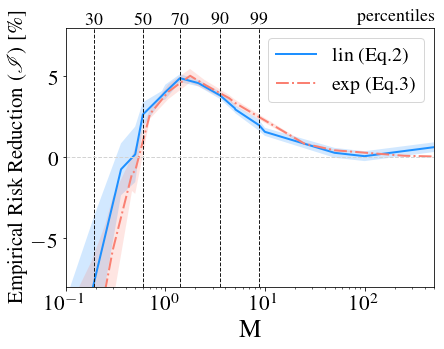

In [17]:
start_plotting(cmbright=False, left=0.15)

x,y,yerr = extract_mean_std(df_lin, "M", COL)
errorfill(x, y, yerr, label="lin (Eq.2)", color="dodgerblue", ls="-")

x,y,yerr = extract_mean_std(df_exp2, "M", COL)
errorfill(x, y, yerr, label="exp (Eq.3)", color="salmon", ls="-.")


plt.xscale("log")
plt.legend(fontsize=20)
plt.xlabel("M")
plt.ylabel("Empirical Risk")
plt.xlim(0.1,500)
plt.ylim(-8,8) 

xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
ymax = ymax*1.02
for p, M in zip(selected_percentiles, selected_Ms):
    if M<xmin or M>xmax: continue
    plt.axvline(M, color="k", ls="--", lw=1)
    plt.text(M, ymax, "%s" % p, ha="center", fontsize=18)
plt.text(xmax, ymax, "percentiles", ha="right", va="bottom", fontsize=18)

plt.axhline(0, color="lightgray", ls="--", lw=1)
plt.ylabel("Empirical Risk Reduction ($\mathcal{I}$) [\%]", fontsize=21)
plt.savefig("mf_lin_M_exp_gamma.pdf")
plt.show()